In [1]:
import numpy as np
import random
from numpy.random import multivariate_normal as randN
from scipy.stats import multivariate_normal
from scipy.special import gamma, kv

import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
random.seed(1234)

 ## helper functions for all MCMC

In [4]:
def prior(params):
    return 1

#Defines whether to accept or reject the new sample
def acceptance(log_pi, log_pi_new, proposal_ratio=1):
    accept=np.random.uniform(0,1)
    acc_ratio = np.exp(log_pi_new-log_pi)*proposal_ratio
    sig = 0
    if accept < acc_ratio:
        sig = 1
    if acc_ratio > 1:
        acc_ratio = 1
    return sig, acc_ratio

# compute autocorrelation at dimension dim
def autocorrelation(samples, dim, max_lag):
    x_j = samples[:, dim]
    tmp = x_j - np.mean(x_j)
    C_0 = np.sum(tmp**2)
    auto_correlation = np.correlate(tmp, tmp, "same")
    auto_correlation = auto_correlation / C_0
    # auto correlation is symmetric
    init = int((len(auto_correlation)/2))
    return auto_correlation[init:init+max_lag]
 
# plot autocorrelation 
def plot_autocorr(samples, max_lag=200, y_max = 0.2, y_min = -0.1):
    n, d = samples.shape
    for dim in range(d):
        A = autocorrelation(samples, dim, max_lag)
        label_dim = "dim = " + str(dim)
        plt.plot(A, label=label_dim)
    plt.title('Auto-correlation for all dimensions in the sample')    
    plt.xlabel('lag')
    plt.ylim((y_min, y_max))
    plt.ylabel('Auto-correlation')
    plt.legend()
    plt.show()

## Defining Counterexample

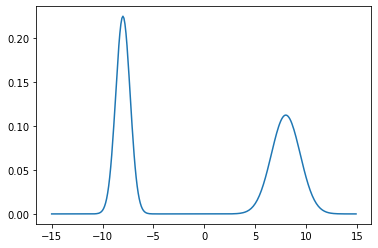

In [5]:
def counter_posterior(x, data):
    mean1 = np.array([-8, 0])
    cov1 = np.array([[0.5,0],[0,0.5]], dtype=np.float32)
    mean2 = np.array([8, 0])
    cov2 = np.array([[2,0],[0,2]], dtype=np.float32)
    res = 0
    res += np.exp(-0.5*(x-mean1).T@np.linalg.inv(cov1)@(x-mean1))/np.sqrt(2*(np.pi**2)*np.linalg.det(cov1))/2
    res += np.exp(-0.5*(x-mean2).T@np.linalg.inv(cov2)@(x-mean2))/np.sqrt(2*(np.pi**2)*np.linalg.det(cov2))
    return np.log(res)
res = []
for x in np.arange(-15.0,15.0,0.1):
    res.append(counter_posterior(np.array([x, 0]), 1))
plt.plot(np.arange(-15.0,15.0,0.1), np.exp(res))
# no data for counter example posterior
data1 = np.array([])

## Kernel Gradient Matrix

In [8]:
###############################################################################################################
# Computes gradient of a guassian kernel
def get_grad_Guassian(bandwidth=1.0):
    def grad_func(x, x_prime):
        # guassian kernel function
        def k(x, x_prime, bandwidth):
            tmp_1 = -1 * np.linalg.norm(x-x_prime)**2
            tmp_2 = 2*bandwidth**2
            return np.exp(tmp_1/tmp_2)
        k_x_xp = k(x, x_prime, bandwidth)
        return 1/(bandwidth**2)*k_x_xp*(x_prime-x)
    return grad_func

# Computes gradient of a linear kernel
def get_grad_Linear():
    def grad_func(x, x_prime):
        return x_prime
    return grad_func

# Computes gradient of a Matérn kernel
def get_grad_Matern(l=1.0, v=1.5):
    def grad_func(x, x_prime):
        # Matérn kernel function
        def k(x, x_prime, l, v):
            scale = 1 / (gamma(v)* 2**(v-1) )
            tmp = (np.sqrt(2*v)/l) * np.linalg.norm(x-x_prime)
            if tmp == 0:
                return 1.0
            else:
                return scale * tmp**v *kv(v, tmp)
        tmp_out = v/(l**2 * (v-1))
        return tmp_out * k(x, x_prime, l, v-1) * (x_prime - x)
    return grad_func 

###############################################################################################################
# computes a kernel gradient matrix d x m, m = min{subsample_size, len(history)}
# x:              current position, of dim=d
# history:        chain history of accepted positions d x t
# gradK:          function to compute the gradient of a kernel function w.r.t x
# idx:            idx for the subsample of chain history
# Returns:        M, the kernel gradient matrix d x m
def get_kernel_grad_matrix(x, history, idx, gradK):
    d, t = history.shape
    m = len(idx)
    M = np.zeros([d, m])
    count = 0
    for i in range(m):
        M[:, i] = 2 * gradK(x, history[:, idx[i]])
        count+=1
    return M

# get centraling matrix H
# m:              min{subsample_size, len(history)}
# Returns:        centraling matrix H
def get_centraling_matrix(m):
    I = np.identity(m)
    ones = np.ones([m, m])
    H = I - ones/m
    return H

## Schedulers

In [17]:
# get idx for subsample z, resample z with decreasing probability {p_t} 
# iterations:       total number of iterations, p_0 = 1.0, p_iterations = 0.01
# decay_rate:       controls p_t to be an exponential decay rate, with decay_rate in (0, 1) controls half-life
# subsample_size:   number of subsamples from chain history
# w_replacement:    subsample with or without replacement
# returns:          a function that takes in 1) current idx list, 2) history
#                   and generates a new idx list with prob p_t
def idx_scheduler(iterations, decay_rate=0.5, subsample_size=50, w_replacement=False):
    t_half = iterations/(2/decay_rate)
    gamma = np.log(2)/t_half
    t = np.linspace(0, iterations)
    p_t = np.exp(-gamma*t)
    fig = plt.figure(); plt.plot(t, p_t, 'r'); plt.title("resample probability $p_t$ schedule"); plt.show()
    def idx_func(idx, history):
        if len(idx) == 0:
            return idx
        _, current_t = history.shape
        p_t = np.exp(-gamma * current_t)
        m = min(subsample_size, current_t)
        dice = np.random.uniform(0,1)
        if dice > p_t:
            idx = np.random.choice(current_t, m, replace=w_replacement)  
        return idx
    return idx_func

# noise scheduler, decaying from initial_noise -> final_noise
# iterations:       total number of iterations, p_0 = 1.0, p_iterations = 0.01
# initial_noise:    starting value for noise in KAM proposal
# final_noise:      final value for noise
# decay_rate:       controls the rate of decay, value in (0,1)
# returns:          a function that takes in current iteration t, and returns noise for that t
def decaying_noise_scheduler(iterations, initial_noise=4, final_noise=0.2, decay_rate=0.55):
    tmp = (final_noise/initial_noise) ** (1/decay_rate)
    b = (tmp*iterations) / (1 - tmp)
    a = initial_noise* b ** decay_rate
    t = np.linspace(0, iterations)
    noise_t = a * (b + t)**(-decay_rate)
    # plot for visualization
    fig = plt.figure(); plt.plot(t, noise_t, 'b'); plt.title("noise term $\gamma$ schedule"); plt.show()
    def noise_func(current_t):
        return a * (b + current_t)**(-decay_rate)
    return noise_func

# noise scheduler, constant noise
def constant_noise_scheduler(noise=0.2):
    def noise_func(current_t):
        return noise
    return noise_func

# the modified cyclical stepsize scheduler, 
# recomputes theoretical initial stepsize from the last step in Exploration
# iterations_cycle:       number of iterations in a cycle
# stepsize_exp:           the last stepsize in Exploration
# beta:                   proportion of exploration   
# returns:                a function that takes in current iteration t in the cycle, and returns its stepsize
def modified_cyclical_stepsize_scheduler(iterations_cycle, stepsize_exp, beta=0.4):
    stepsize_init = (2 * stepsize_exp) / (np.cos(beta * np.pi) + 1)
#     t = np.linspace(0, iterations_cycle)
#     tmp_plot = np.cos(np.pi * t/iterations_cycle)
#     stepsize_plot = (stepsize_init/2) * (tmp_plot + 1)
#     fig = plt.figure(); plt.plot(t, stepsize_plot, 'b'); plt.title("stepsize per cycle"); plt.show()
    def stepsize_func(current_t_cycle):
        tmp = np.cos(np.pi * current_t_cycle/iterations_cycle)
        stepsize_current = (stepsize_init/2) * (tmp + 1)
        return stepsize_current
    return stepsize_func

## Random Walk proposal

In [20]:
# Propose the next position x' with RW proposal 
# x:               current position, of dim=d
# stepsize:        current stepsize
# Sigma:           covariance matrix
# Returns:         the proposed position x'
def RW_proposal(x, stepsize, Sigma):
    x_prime =  randN(x, stepsize**2*Sigma)
    return x_prime

## KAM proposal

In [26]:
# Propose the next position x' with KAM proposal, also computes the proposal ratio
# x:               current position, of dim=d
# history:         chain history of accepted positions d x t
# gradK:           function to compute the gradient of a kernel function w.r.t x
# stepsize:        current stepsize
# noise:           noise term gamma
# idx:             idx for subsample z of chain history 
# Returns:         the proposed position x', proposal_ratio q(x|x')/q(x'|x), [optionally] cov_forward
def KAM_proposal(x, history, gradK, stepsize, idx, noise, return_cov=False):
    d, t = history.shape
    if t == 0:
        x_prime = randN(x, noise**2 * np.identity(d))
        return x_prime, 1
    else:
        m = len(idx)
        M = get_kernel_grad_matrix(x, history, idx, gradK)
        H = get_centraling_matrix(m)
        cov_forward = noise**2 * np.identity(d) + stepsize**2 * (M @ H @ M.T)
        var_forward = multivariate_normal(mean=x, cov=cov_forward, allow_singular=True)
        # propose next position x'
        x_prime = randN(x, cov_forward)
        # compute q(x'|x)
        q_forward = var_forward.pdf(x_prime)
        M_prime = get_kernel_grad_matrix(x_prime, history, idx, gradK)
        cov_reverse = noise**2 * np.identity(d) + stepsize**2 * (M_prime @ H @ M_prime.T)
        var_reverse = multivariate_normal(mean=x_prime, cov=cov_reverse, allow_singular=True)
        # compute q(x|x')
        q_reverse = var_reverse.pdf(x)
        if return_cov:
            return x_prime, q_reverse/q_forward, cov_forward
        else:
            return x_prime, q_reverse/q_forward

## cKAM Sampler

In [24]:
def cKAM(likelihood_computer, prior, x_init, iterations_cycle, n_cycles, beta,
        data, acceptance_rule, stepsize_init, 
        gradK, idx_scheduler, noise_scheduler, eps=0.75, optim_acc=0.234):
    # initialization of entire chain
    x = np.array(x_init); samples = []; accept_acc = 0;
    # begin sampling
    for cycle in tqdm(range(n_cycles)):
        # initialization of cycle
        idx = np.empty(0); history = np.empty([len(x),0]); stepsize = stepsize_init
        # number of iterations for exploration 
        iteration_exp = int(beta*iterations_cycle)
        ################### Exploration phase ###################
        for i in range(iteration_exp):
            # Exploration phase
            idx = idx_scheduler(idx, history)
            noise = noise_scheduler(i)
            # if at last step, record cov_exp
            if i == (iteration_exp-1):
                x_prime, proposal_ratio, cov_exp = KAM_proposal(x, history, gradK, stepsize, idx, noise, return_cov=True)
            else:
                x_prime, proposal_ratio = KAM_proposal(x, history, gradK, stepsize, idx, noise)
            # MH step
            log_pi = likelihood_computer(x, data) + np.log(prior(x))
            log_pi_prime = likelihood_computer(x_prime, data) + np.log(prior(x_prime))
            sig, acc_ratio = acceptance_rule(log_pi, log_pi_prime, proposal_ratio)
            if sig: x = x_prime
            # Adapting stepsize
            eta = 1 / (1+i)**eps
            stepsize = np.exp(np.log(stepsize) + eta*(acc_ratio - optim_acc))
            # adding to chain history 
            history = np.hstack((history, x.reshape((-1,1))))
        ###################    Transition    ###################
        Sigma = cov_exp / (stepsize**2); stepsize_exp = stepsize
        stepsize_schedule = modified_cyclical_stepsize_scheduler(iterations_cycle, stepsize_exp, beta)
        ###################  Sampling phase  ###################
        for i in range(iterations_cycle - iteration_exp):
            stepsize = stepsize_schedule(i+iteration_exp)
            x_prime = RW_proposal(x, stepsize, Sigma)
            log_pi = likelihood_computer(x, data) + np.log(prior(x))
            log_pi_prime = likelihood_computer(x_prime, data) + np.log(prior(x_prime))
            # MH step
            sig, acc_ratio = acceptance_rule(log_pi, log_pi_prime, 1)
            if sig: 
                x = x_prime; accept_acc += 1
            samples.append(x)
    avg_acc = accept_acc / (iterations_cycle*(1-beta)*n_cycles)
    return np.array(samples), avg_acc

# cKAM on counter example

### decaying noise can escape local mode

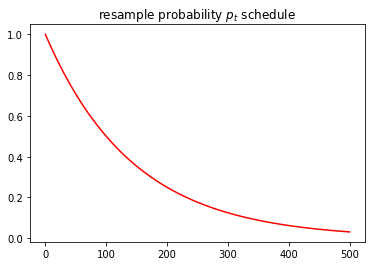

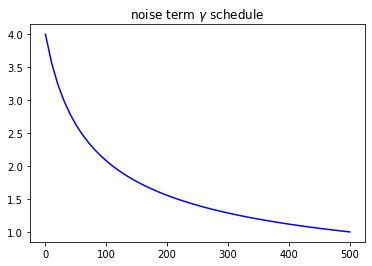

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:50<00:00,  7.89it/s]


Density of the samples:


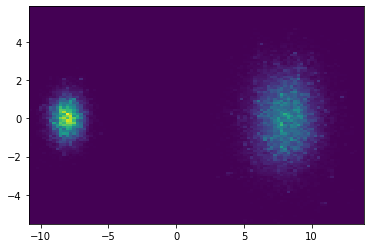

Average acceptance ratio is: 0.7207785714285714


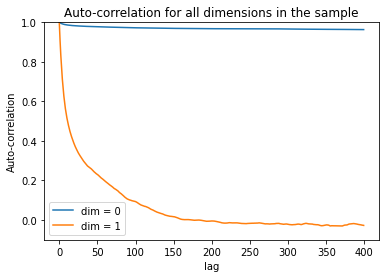

histogram along dim 0:


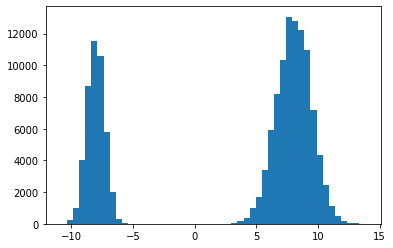

histogram along dim 1:


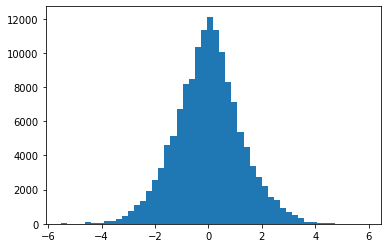

In [60]:
np.random.seed(1234)
iterations_cycle=500; beta=0.3; n_cycles=400; initial_stepsize= 4*2.38**2/2
# get externel functions
gradk = get_grad_Matern(l=2, v=4)
idx_schedule = idx_scheduler(iterations_cycle, subsample_size=50, decay_rate=0.4)
noise_schedule = decaying_noise_scheduler(iterations_cycle, initial_noise=4, final_noise=1, decay_rate=0.55)
# begin training 
samples_cKAM, avg_acc = cKAM(counter_posterior, prior, [-8, 0], iterations_cycle, n_cycles, beta,
                                     data1, acceptance, initial_stepsize, gradk, idx_schedule, noise_schedule,
                                     eps=2, optim_acc=0.234)
print("Density of the samples:")
plt.hist2d(samples_cKAM[:,0], samples_cKAM[:,1], bins=100)
plt.show()
print("Average acceptance ratio is:", avg_acc)
plot_autocorr(samples_cKAM, max_lag=400, y_max = 1, y_min = -0.1)
print("histogram along dim 0:")
plt.hist(samples_cKAM[:,0], bins=50)
plt.show()
print("histogram along dim 1:")
plt.hist(samples_cKAM[:,1], bins=50)
plt.show()